In [1]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Orbitron&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Orbitron; color:#ff1155;'>
    %s</h1>"""%str))

In [2]:
dhtml('Code Modules, Functions, & Classes')

In [3]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch,time,copy,urllib,zipfile
from torchvision.datasets import CIFAR10 as tcifar10
from torchvision import transforms,utils,models
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
from torch.utils.data.dataset import Subset
import torch.nn.functional as tnnf
import torch.nn as tnn
import tensorflow.image as timage
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")
pl.ion() 

In [4]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [5]:
@register_line_magic
def display_examples(data):
    for images,labels in dataloaders2[data]:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(10,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i]).reshape(img_size,img_size,3))
        break
def show_image(img):
    npimg=img.numpy()/2.+.5; tr=(1,2,0)
    pl.figure(figsize=(10,2))
    pl.imshow(np.transpose(npimg,tr))
    pl.xticks([]); pl.show()
@register_line_magic
def show_examples(data):
    dataiter=iter(dataloaders[data])
    images,labels=dataiter.next()
    show_image(utils.make_grid(images[0:5]))
    print('^'.join('%11s'%classes[labels[j]] 
                   for j in range(5)),end='^')

In [6]:
dhtml('Data')

In [7]:
img_size=32
classes=('plane','car','bird','cat','deer',
          'dog','frog','horse','ship','truck')
random_seed=12; batch_size=256
train_ids=torch.arange(0,44000)
valid_ids=torch.arange(44000,50000)
tr0=(.5,.5,.5)
train_transform=transforms\
.Compose([transforms.ToTensor(),
          transforms.Normalize(tr0,tr0)])
test_transform=transforms\
.Compose([transforms.ToTensor(),
          transforms.Normalize(tr0,tr0)])
train_valid=tcifar10(root='data',train=True,
                     download=True,
                     transform=train_transform)
train=Subset(train_valid,train_ids)
valid=Subset(train_valid,valid_ids)
test=tcifar10(root='data',train=False, 
              transform=test_transform)
dataloaders={'train':tdl(dataset=train,shuffle=True, 
                         batch_size=batch_size), 
             'valid':tdl(dataset=valid,shuffle=True, 
                         batch_size=batch_size),
             'test':tdl(dataset=test,shuffle=True, 
                        batch_size=batch_size)}

Files already downloaded and verified


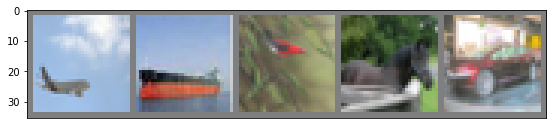

      plane^       ship^       bird^      horse^        car^

In [8]:
%show_examples test

In [9]:
fpath='https://olgabelitskaya.github.io/'
zf='LetterColorImages_123.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys()); print(keys)
x=np.array(f[keys[1]],dtype='float32')
x=x.reshape(-1,3,img_size,img_size)/255
print(x.mean(),x.std())
y=np.array(f[keys[2]],dtype='int32')-1
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids],y[shuffle_ids]
x_test,x_valid,x_train=x[:n],x[n:2*n],x[2*n:]
y_test,y_valid,y_train=y[:n],y[n:2*n],y[2*n:]

['backgrounds', 'images', 'labels']
0.5900519 0.1395963


In [10]:
random_seed=23; batch_size2=128
train2=TData(x_train,y_train)
valid2=TData(x_valid,y_valid)
test2=TData(x_test,y_test)
dataloaders2={'train':tdl(dataset=train2,shuffle=True, 
                          batch_size=batch_size), 
              'valid':tdl(dataset=valid2,shuffle=True, 
                          batch_size=batch_size),
              'test':tdl(dataset=test2,shuffle=True, 
                         batch_size=batch_size)}

Image dimensions: torch.Size([256, 3, 32, 32])
Label dimensions: torch.Size([256])


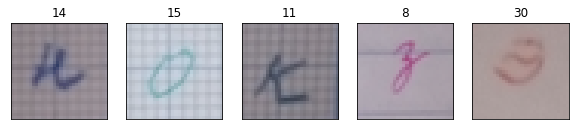

In [11]:
%display_examples valid

In [12]:
dhtml('Model Loading and Training')

In [13]:
def train_model(model,dataloaders,criterion,optimizer,
                scheduler,num_epochs):
    start=time.time(); best_acc=0.
    best_model_wts=copy.deepcopy(model.state_dict())
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1,num_epochs))
        print('-'*10)
        for phase in ['train','valid']:
            if phase=='train': model.train()
            else: model.eval()
            running_loss=0.; running_corrects=0
            for images,labels in dataloaders[phase]:
                images=images.to(dev)
                labels=labels.to(dev).long()
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs=model(images)
                    _, preds=torch.max(outputs,1)
                    loss=criterion(outputs,labels)
                    if phase=='train':
                        loss.backward(); optimizer.step()
                running_loss+=loss.item()*images.size(0)
                running_corrects+=torch.sum(preds==labels.data)
            if phase=='train': scheduler.step()
            epoch_loss=running_loss/dataset_sizes[phase]
            epoch_acc=running_corrects.double()/dataset_sizes[phase]
            print('phase: {} loss: {:.4f} acc: {:.4f}'\
                  .format(phase,epoch_loss,epoch_acc))
            if phase=='valid' and epoch_acc>best_acc:
                best_acc=epoch_acc
                best_model_wts=copy.deepcopy(model.state_dict())
    time_elapsed=time.time()-start
    print('training time: {:.0f}m {:.0f}s'\
          .format(time_elapsed//60,time_elapsed%60))
    print('best valid acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [14]:
num_classes=10; learning_rate=.00005
dataset_sizes={'train':44000,'valid':6000}
model_ft=models.resnet18(pretrained=True)
num_ftrs=model_ft.fc.in_features
model_ft.fc=tnn.Linear(num_ftrs,num_classes)
model_ft=model_ft.to(dev)
criterion=tnn.CrossEntropyLoss()
optimizer_ft=torch.optim.Adam(model_ft.parameters(),
                              lr=learning_rate)
exp_lr_scheduler=torch.optim.lr_scheduler\
.StepLR(optimizer_ft,step_size=5,gamma=.5)

In [15]:
model_ft=train_model(model_ft,dataloaders,criterion,
                     optimizer_ft,exp_lr_scheduler,
                     num_epochs=25)

Epoch 1/25
----------
phase: train loss: 1.4015 acc: 0.5118
phase: valid loss: 0.9413 acc: 0.6808
Epoch 2/25
----------
phase: train loss: 0.7773 acc: 0.7311
phase: valid loss: 0.7832 acc: 0.7270
Epoch 3/25
----------
phase: train loss: 0.5583 acc: 0.8104
phase: valid loss: 0.7384 acc: 0.7495
Epoch 4/25
----------
phase: train loss: 0.4038 acc: 0.8665
phase: valid loss: 0.7310 acc: 0.7575
Epoch 5/25
----------
phase: train loss: 0.2790 acc: 0.9119
phase: valid loss: 0.7654 acc: 0.7615
Epoch 6/25
----------
phase: train loss: 0.1715 acc: 0.9537
phase: valid loss: 0.7800 acc: 0.7635
Epoch 7/25
----------
phase: train loss: 0.1260 acc: 0.9700
phase: valid loss: 0.8032 acc: 0.7617
Epoch 8/25
----------
phase: train loss: 0.0935 acc: 0.9803
phase: valid loss: 0.8433 acc: 0.7647
Epoch 9/25
----------
phase: train loss: 0.0703 acc: 0.9868
phase: valid loss: 0.8778 acc: 0.7610
Epoch 10/25
----------
phase: train loss: 0.0523 acc: 0.9920
phase: valid loss: 0.9149 acc: 0.7647
Epoch 11/25
-------

In [16]:
dhtml('Model Evaluation')

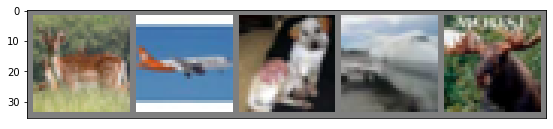


true labels:       deer    plane      dog    plane     deer

predictions:       deer    plane      dog    plane     deer


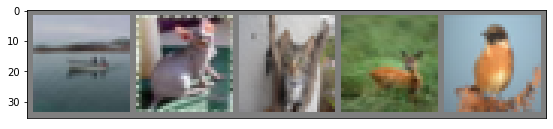


true labels:       ship      cat      cat     deer     bird

predictions:       ship      cat      cat     deer     bird


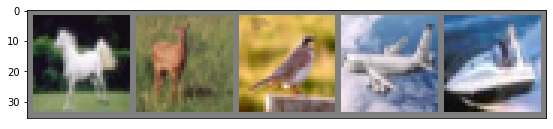


true labels:      horse     deer     bird    plane     ship

predictions:      horse     deer     bird    plane     ship


In [17]:
with torch.no_grad():
    for i,(images,labels) in enumerate(dataloaders['train']):
        show_image(utils.make_grid(images[:5]))
        print('\ntrue labels: ',
              ''.join('%9s'%classes[labels[j]] 
                       for j in range(5)))
        images=images.to(dev)
        labels=labels.to(dev)
        outputs=model_ft(images)
        _,preds=torch.max(outputs,1)
        print('\npredictions: ',
             ''.join('%9s'%classes[preds[j]]
                      for j in range(5)))
        if i==2: break

In [18]:
dhtml('Model Training')

In [19]:
num_classes=33; learning_rate=.0005
dataset_sizes={'train':x_train.shape[0],
               'valid':x_valid.shape[0]}
model_ft=models.resnet18(pretrained=True)
num_ftrs=model_ft.fc.in_features
model_ft.fc=tnn.Linear(num_ftrs,num_classes)
model_ft=model_ft.to(dev)
criterion=tnn.CrossEntropyLoss()
optimizer_ft=torch.optim.Adam(model_ft.parameters(),
                              lr=learning_rate)
exp_lr_scheduler=torch.optim.lr_scheduler\
.StepLR(optimizer_ft,step_size=5,gamma=.5)

In [20]:
model_ft=train_model(model_ft,dataloaders2,criterion,
                     optimizer_ft,exp_lr_scheduler,
                     num_epochs=15)

Epoch 1/15
----------
phase: train loss: 2.8876 acc: 0.1949
phase: valid loss: 2.3425 acc: 0.3009
Epoch 2/15
----------
phase: train loss: 1.8306 acc: 0.4571
phase: valid loss: 2.8231 acc: 0.2861
Epoch 3/15
----------
phase: train loss: 1.3163 acc: 0.6048
phase: valid loss: 1.8154 acc: 0.4863
Epoch 4/15
----------
phase: train loss: 0.9294 acc: 0.7181
phase: valid loss: 1.9006 acc: 0.4870
Epoch 5/15
----------
phase: train loss: 0.6639 acc: 0.7966
phase: valid loss: 1.7252 acc: 0.5398
Epoch 6/15
----------
phase: train loss: 0.3470 acc: 0.9004
phase: valid loss: 1.3656 acc: 0.6251
Epoch 7/15
----------
phase: train loss: 0.1544 acc: 0.9657
phase: valid loss: 1.4195 acc: 0.6237
Epoch 8/15
----------
phase: train loss: 0.0811 acc: 0.9857
phase: valid loss: 1.4362 acc: 0.6364
Epoch 9/15
----------
phase: train loss: 0.0463 acc: 0.9932
phase: valid loss: 1.5101 acc: 0.6342
Epoch 10/15
----------
phase: train loss: 0.0320 acc: 0.9966
phase: valid loss: 1.6066 acc: 0.6300
Epoch 11/15
-------

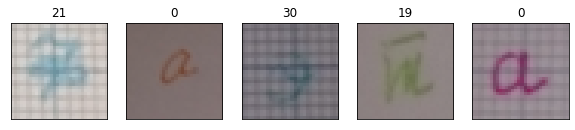


true labels:          ф        а        э        т        а

predictions:          щ        а        э        ё        а


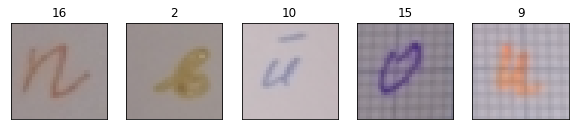


true labels:          п        в        й        о        и

predictions:          г        я        й        о        х


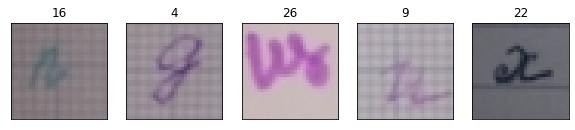


true labels:          п        д        щ        и        х

predictions:          п        з        щ        м        ц


In [21]:
letters=u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
with torch.no_grad():
    for i,(images,labels) in enumerate(dataloaders2['test']):
        fig=pl.figure(figsize=(10,4))
        for k in range(5):
            ax=fig.add_subplot(1,5,k+1,\
            xticks=[],yticks=[],title=labels[k].item())
            ax.imshow((images[k])\
                      .reshape(img_size,img_size,3))
        pl.show()
        print('\ntrue labels: ',
             ''.join('%9s'%letters[labels[j]]
                      for j in range(5)))
        images=images.to(dev)
        labels=labels.to(dev).long()
        outputs=model_ft(images)
        _,preds=torch.max(outputs,1)
        print('\npredictions: ',
             ''.join('%9s'%letters[preds[j]]
                      for j in range(5)))
        if i==2: break

In [22]:
class LiveTrainPlot(object):
    def __init__(self,labels,xlim='auto',ylim='auto',
                 xlabel='Epochs',ylabel='Parameters'):
        self.xlim=xlim; self.ylim=ylim
        fig,ax=pl.subplots(1,1)
        self.ax=ax; self.fig=fig       
        self.labels=labels
        for label in self.labels:
            self.ax.plot([0],'-o',label=label)
        if not xlim=='auto':
            self.ax.set_xlim(self.xlim)
        if not ylim=='auto':
            self.ax.set_ylim(self.ylim)
        self.ax.set_xlabel(xlabel)
        self.ax.set_ylabel(ylabel)
        self.ax.legend()      
        self.max=-np.inf; self.min=np.inf
        self.num_iter=0
    def update(self,data_dict):             
        self.num_iter+=1       
        if self.xlim=='auto':
            self.ax.set_xlim(0,self.num_iter)        
        changed=False
        for i,label in enumerate(self.labels):           
            line=self.ax.lines[i]
            line.set_xdata(data_dict[label][0])
            line.set_ydata(data_dict[label][1])           
            recent_y_value=data_dict[label][1][-1]
            if self.ylim=='auto':
                changed=False
                if recent_y_value>self.max:
                    self.max=recent_y_value
                    changed=True
                if recent_y_value<self.min:
                    self.min=recent_y_value
                    changed=True                   
            if changed:  
                self.ax.set_ylim(self.min*.995,self.max*1.005)
            self.fig.canvas.draw()

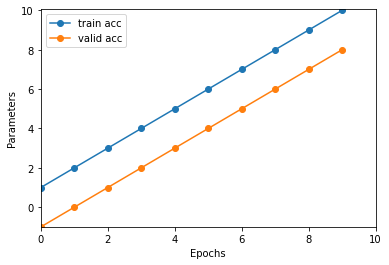

In [23]:
#check class construction
plot=LiveTrainPlot(labels=['train acc','valid acc'])
x1,y1,x2,y2=[],[],[],[]
for i in range(10):
    time.sleep(.1)
    x1.append(i); y1.append(i+1)    
    x2.append(i); y2.append(i-1)   
    data_dict={'train acc':[x1,y1],
               'valid acc': [x2,y2]}
    plot.update(data_dict=data_dict)